In [3]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#sampling frequency, 256Hz
dt       = 1.0/256.0

max_velocity = 1

#continuous time dynamics, servo model, with inertia
mat_a = numpy.zeros((2, 2))
mat_b = numpy.zeros((2, 1))
mat_c = numpy.eye(2)

tau = 0.01

mat_a[0][0] = -1.0/tau
mat_a[1][0] = 1.0
mat_b[0][0] = 1.0/tau



print("continuous model")
print(mat_a)
print(mat_b)
print()

#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


#create loss weighting matrices (diagonal)
q = numpy.diag([0.0, 1.0] )
r = numpy.diag( [1.0]) 

#process and observation noise covariance
q_noise = 0.1*numpy.eye(ds.a.shape[0]) 
r_noise = 0.1*numpy.eye(ds.c.shape[0]) 
 

a_disc, b_disc, c_disc = LibsControl.c2d(ds.a, ds.b, ds.c, dt)

print("discrete model")
print(a_disc)
print(b_disc)
print()


#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_disc, b_disc, c_disc, q, r, q_noise, r_noise, max_velocity)

print("k  = ", lqg.k)
print("ki = ", lqg.ki)
print("f  = ", lqg.f)


continuous model
[[-100.    0.]
 [   1.    0.]]
[[100.]
 [  0.]]

discrete model
[[0.67320261 0.        ]
 [0.00326797 1.        ]]
[[0.32679739]
 [0.00063828]]

k  =  [[ 0.2301629  26.18237104]]
ki =  [[0.         1.04495369]]
f  =  [[5.55940936e-01 2.34193115e-04]
 [2.34193115e-04 6.18035120e-01]]


(1000, 1)
(1000, 1)
(1000, 2)


<Figure size 640x480 with 0 Axes>

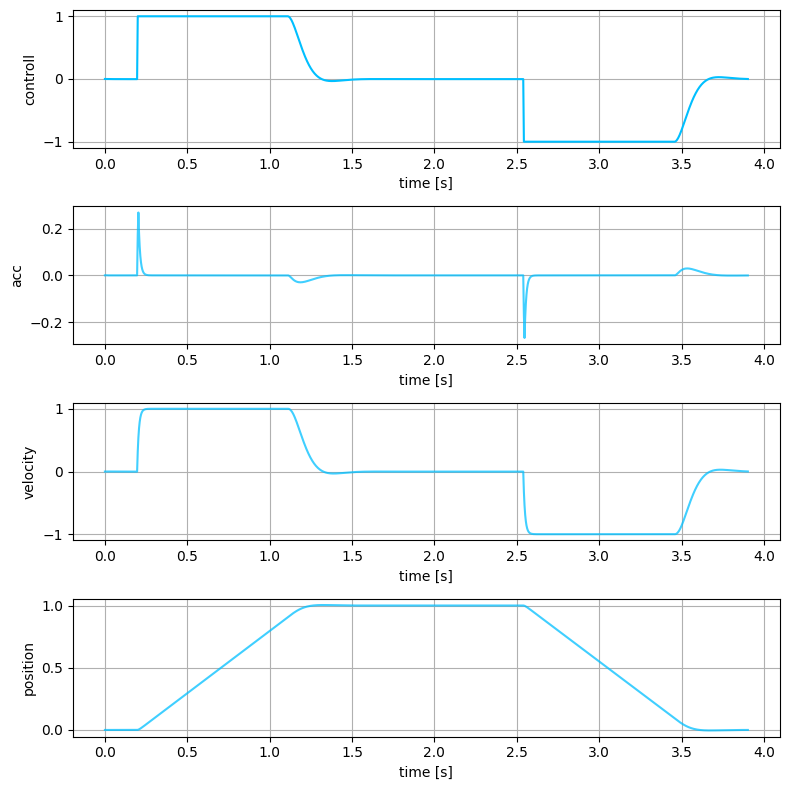

In [4]:

#process simulation
n_max = 1000

#observed state
x_hat = numpy.zeros((mat_a.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
u_result = []
a_result = []
a_result = []
x_result = []



v_prev = 0.0

#initial motor state
ds.reset()

#plant output
y = ds.y


saturation = False
acc_max = 0.05


for n in range(n_max):

    #required position  
    yr = numpy.zeros((mat_c.shape[0], 1))

    if n > 0.65*n_max:
        yr = numpy.zeros((mat_c.shape[0], 1))
    elif n > 0.05*n_max:
        yr = numpy.ones((mat_c.shape[0], 1))
    else:
        yr = numpy.zeros((mat_c.shape[0], 1))


    #compute controller output
    u, integral_action, x_hat = lqg.forward(yr, y, integral_action, x_hat)
    
    
    #compute plant output
    x, y = ds.forward_state(u)

    v = y[0, 0]
    acc = v - v_prev
    v_prev = v

    
    if numpy.abs(acc) > acc_max:
        saturation = True
    else:
        saturation = False
    

    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    a_result.append(acc)
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
a_result = numpy.array(a_result)
x_result = numpy.array(x_result)


a_result = numpy.expand_dims(a_result, 1)

print(u_result.shape)
print(a_result.shape)
print(x_result.shape)

x_result = numpy.concatenate([a_result, x_result], axis=1)

#plot results
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["controll"], x_labels = ["acc", "velocity", "position"])
